### Lesson 5 Assignment - Breast Cancer Detection
### Lawrence Huang
##### Instructions
Using the WI_Breast_Cancer csv file, create a new notebook to build a decision tree classifier that would be able to detect whether a tumor is benign or malignant. Complete the following tasks and answer the questions:

1. Test both entropy and the gini coefficient. Which performs better and why?
2. What are the best hyperparameter settings for both?
3. Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?
4. Determine the AUC for the best model you can achieve. What are the precision and recal values and which might be the one you want to maximize?
6. What are the implications of using this type of machine learning algorithm for breast cancer analysis?

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import os
from IPython.display import Image

##### Preprocessing

In [2]:
# load data
filename = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/WI_Breast_Cancer.csv'
df = pd.read_csv(filename, header=None)
# add column names
df.columns = ['Sample code number', 'Class', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
              'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitosis']
# preview data
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(709, 11)


,Sample code number,Class,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitosis
0,1000025,2,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1
1,1002945,2,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1
2,1015425,2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1
3,1016277,2,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1
4,1017023,2,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1


In [3]:
# remove ID which would not be predictive 
df.drop('Sample code number', axis=1, inplace=True)

In [4]:
# per data source, all data are numeric 
# view dataframe dtype 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 10 columns):
Class                          702 non-null object
Clump Thickness                702 non-null float64
Uniformity of Cell Size        701 non-null float64
Uniformity of Cell Shape       701 non-null float64
Marginal Adhesion              701 non-null float64
Single Epithelial Cell Size    701 non-null float64
Bare Nuclei                    701 non-null float64
Bland Chromatin                701 non-null float64
Normal Nucleoli                701 non-null float64
Mitosis                        701 non-null object
dtypes: float64(8), object(2)
memory usage: 55.5+ KB


In [5]:
# investigate Class which is object type
print(df['Class'].value_counts())
df[(df['Class']!='2') & (df['Class']!='4')]
# the strange entry (1990;...) will be dropped when dropping missing values

2                       458
4                       243
 1990; Updated Jan 8      1
Name: Class, dtype: int64


,Class,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitosis
367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,1990; Updated Jan 8,1991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# investigate Mitosis which is object type
print(df['Mitosis'].value_counts())
# change everything that starts with '3' to '3'
df.loc[df['Mitosis'].str.startswith('3', na=False), 'Mitosis'] = '3'
print('\nafter repalcement:')
print(df['Mitosis'].value_counts())

1                                    579
2                                     35
3                                     33
10                                    14
4                                     12
7                                      9
8                                      8
5                                      6
6                                      3
3) <-----Reappears in Group 8 as:      1
3                                      1
Name: Mitosis, dtype: int64

after repalcement:
1     579
2      35
3      35
10     14
4      12
7       9
8       8
5       6
6       3
Name: Mitosis, dtype: int64


In [7]:
# change null/missing values to nan
df = df.apply(pd.to_numeric, errors='coerce')
# print number of missing values
print('\n# of missing values:\n{}'.format(df.isna().sum()))

# change Class to 0 and 1
df['Class'] = df['Class'].map({2:0, 4:1}) #0: benign, 1:malignant


# of missing values:
Class                          8
Clump Thickness                7
Uniformity of Cell Size        8
Uniformity of Cell Shape       8
Marginal Adhesion              8
Single Epithelial Cell Size    8
Bare Nuclei                    8
Bland Chromatin                8
Normal Nucleoli                8
Mitosis                        8
dtype: int64


In [8]:
# drop missing values
df.dropna(inplace=True)

# preview data
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(701, 10)


,Class,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitosis
0,0.0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0
1,0.0,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0
2,0.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0
3,0.0,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0
4,0.0,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0


In [9]:
# view dataframe dtype after preprocessing
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701 entries, 0 to 708
Data columns (total 10 columns):
Class                          701 non-null float64
Clump Thickness                701 non-null float64
Uniformity of Cell Size        701 non-null float64
Uniformity of Cell Shape       701 non-null float64
Marginal Adhesion              701 non-null float64
Single Epithelial Cell Size    701 non-null float64
Bare Nuclei                    701 non-null float64
Bland Chromatin                701 non-null float64
Normal Nucleoli                701 non-null float64
Mitosis                        701 non-null float64
dtypes: float64(10)
memory usage: 60.2 KB


In [10]:
# no zero variance columns with a single value that are not useful for modeling
print('# unique values:\n{}'.format(df.nunique()))

# unique values:
Class                           2
Clump Thickness                10
Uniformity of Cell Size        10
Uniformity of Cell Shape       10
Marginal Adhesion              10
Single Epithelial Cell Size    10
Bare Nuclei                    11
Bland Chromatin                10
Normal Nucleoli                10
Mitosis                         9
dtype: int64


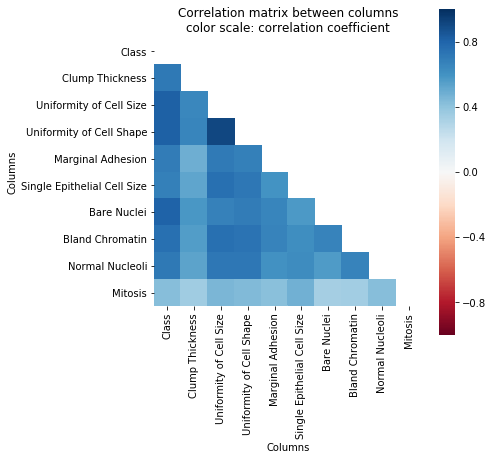

In [11]:
# examine correlation between columns
corrmat = df.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
sns.heatmap(corrmat, mask=mask, vmin=-1, vmax=1, annot=False, square=True, cmap='RdBu', fmt='.2f', ax=ax)
ax.set_title('Correlation matrix between columns\ncolor scale: correlation coefficient')
ax.set_xlabel('Columns')
ax.set_ylabel('Columns')
plt.show()

From the heatmap above, many of the columns are correlated with one another. In particular, <i>Uniformity of Cell Size</i> and <i>Uniformity of Cell Shape</i> have corr coeff of 0.9. 

However, one might expect that if a decision tree used one of the highly correlated variables then it would be less likely to use the other (which turned out to be the case, see tree visualization and feature importance, below). Therefore, for this exercise, all variables are kept at this stage.

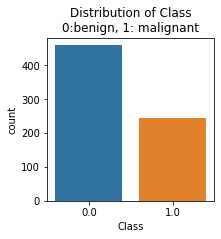

In [12]:
# plot distribution of the target variable Class
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(x='Class', data=df, ax=ax)
plt.title('Distribution of Class\n0:benign, 1: malignant')
plt.show()
# classes are reasonably distributed with ratio of 2:1, not very imbalanced

In [13]:
# train/test split
# stratify to ensure minority class representation in both sets
y = df['Class'] # label
X = df.loc[:, ~df.columns.isin(['Class'])] # features, use all but the target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)
print('features:\n{}'.format(X.columns.values))
print('\n# features: {}'.format(len(X.columns.values)))

# features already on the same scale

features:
['Clump Thickness' 'Uniformity of Cell Size' 'Uniformity of Cell Shape'
 'Marginal Adhesion' 'Single Epithelial Cell Size' 'Bare Nuclei'
 'Bland Chromatin' 'Normal Nucleoli' 'Mitosis']

# features: 9


##### 1. Test both entropy and the gini coefficient. Which performs better and why?

In [14]:
# entropy 
clf_ent = DecisionTreeClassifier(criterion='entropy', random_state=1).fit(X_train, y_train)
y_pred_ent = clf_ent.predict(X_test) 
y_prob_ent = clf_ent.predict_proba(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_ent)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_ent).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_ent))

# determine the AUC
print('AUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_ent[:,1])))

# tree depth and # leaves
print('\nusing default parameters, depth: {}, # leaves: {}'.format(clf_ent.get_depth(), clf_ent.get_n_leaves()))


Confusion Matrix:
[[90  2]
 [ 5 44]]

TP, TN, FP, FN: 44 , 90 , 2 , 5

Classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96        92
         1.0       0.96      0.90      0.93        49

    accuracy                           0.95       141
   macro avg       0.95      0.94      0.94       141
weighted avg       0.95      0.95      0.95       141

AUC score: 0.938

using default parameters, depth: 9, # leaves: 27


In [15]:
# gini
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=1).fit(X_train, y_train)
y_pred_gini = clf_gini.predict(X_test)
y_prob_gini = clf_gini.predict_proba(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gini)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gini).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gini))

# determine the AUC
print('AUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_gini[:,1])))

# tree depth and # leaves
print('\nusing default parameters, depth: {}, # leaves: {}'.format(clf_gini.get_depth(), clf_gini.get_n_leaves()))


Confusion Matrix:
[[90  2]
 [10 39]]

TP, TN, FP, FN: 39 , 90 , 2 , 10

Classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94        92
         1.0       0.95      0.80      0.87        49

    accuracy                           0.91       141
   macro avg       0.93      0.89      0.90       141
weighted avg       0.92      0.91      0.91       141

AUC score: 0.887

using default parameters, depth: 9, # leaves: 35


##### Results:
Using default parameters, the decision tree model using entropy performed better on the test set. Precision, recall, and f1-score on both Classes are higher (same recall for Class 0). AUC is also higher. Importantly, recall on Class 1 is higher (with lower false negatives; see response to question 5, below). 

See response to question 4 for comparison on tuned models using entropy and gini.

##### 2. What are the best hyperparameter settings for both?

In [16]:
# grid search parameters
parameters = [{'max_leaf_nodes': range(2, 42, 2),
               'max_depth': range(4, 33, 4),
               'min_samples_leaf': range(1,16),
               'min_samples_split' : range(2,6)
              }]
print('The following hyperparameters were tuned:\n{}'.format(list(parameters[0].keys())))

The following hyperparameters were tuned:
['max_leaf_nodes', 'max_depth', 'min_samples_leaf', 'min_samples_split']


#### Using entropy:

In [17]:
# using entropy; scoring was set to the average recall for both Classes
gs_ent = GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy', random_state=1),
                      param_grid=parameters, iid=False, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
gs_ent.fit(X_train, y_train)
y_pred_gs_ent = gs_ent.predict(X_test)
y_prob_gs_ent = gs_ent.predict_proba(X_test)

Fitting 5 folds for each of 9600 candidates, totalling 48000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 4372 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 13872 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 27172 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 44272 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 48000 out of 48000 | elapsed:   36.5s finished


In [18]:
# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gs_ent)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gs_ent).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gs_ent))

# determine the AUC
print('AUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_gs_ent[:,1])))


Confusion Matrix:
[[88  4]
 [ 3 46]]

TP, TN, FP, FN: 46 , 88 , 4 , 3

Classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96        92
         1.0       0.92      0.94      0.93        49

    accuracy                           0.95       141
   macro avg       0.94      0.95      0.95       141
weighted avg       0.95      0.95      0.95       141

AUC score: 0.968


#### Using gini:

In [19]:
# using gini; scoring was set to the average recall for both Classes
gs_gini = GridSearchCV(estimator=DecisionTreeClassifier(criterion='gini', random_state=1),
                       param_grid=parameters, iid=False, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
gs_gini.fit(X_train, y_train)
y_pred_gs_gini = gs_gini.predict(X_test)
y_prob_gs_gini = gs_gini.predict_proba(X_test)

Fitting 5 folds for each of 9600 candidates, totalling 48000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5776 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 14776 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 27376 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 43576 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 48000 out of 48000 | elapsed:   37.9s finished


In [20]:
# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gs_gini)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gs_gini).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gs_gini))

# determine the AUC
print('AUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_gs_gini[:,1])))


Confusion Matrix:
[[88  4]
 [ 5 44]]

TP, TN, FP, FN: 44 , 88 , 4 , 5

Classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95        92
         1.0       0.92      0.90      0.91        49

    accuracy                           0.94       141
   macro avg       0.93      0.93      0.93       141
weighted avg       0.94      0.94      0.94       141

AUC score: 0.903


##### Results:

In [21]:
# using entropy
print('Using entropy:')
print('\nBest tuned hyperparameters: {}'.format(gs_ent.best_params_))
print('\nBest estimator:')
print(gs_ent.best_estimator_)
print('-'*80)
# using gini
print('Using gini:')
print('\nBest tuned hyperparameters: {}'.format(gs_gini.best_params_))
print('\nBest estimator:')
print(gs_gini.best_estimator_)

Using entropy:

Best tuned hyperparameters: {'max_depth': 8, 'max_leaf_nodes': 16, 'min_samples_leaf': 2, 'min_samples_split': 2}

Best estimator:
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')
--------------------------------------------------------------------------------
Using gini:

Best tuned hyperparameters: {'max_depth': 8, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best estimator:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                   

##### 3. Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?

Using entropy:


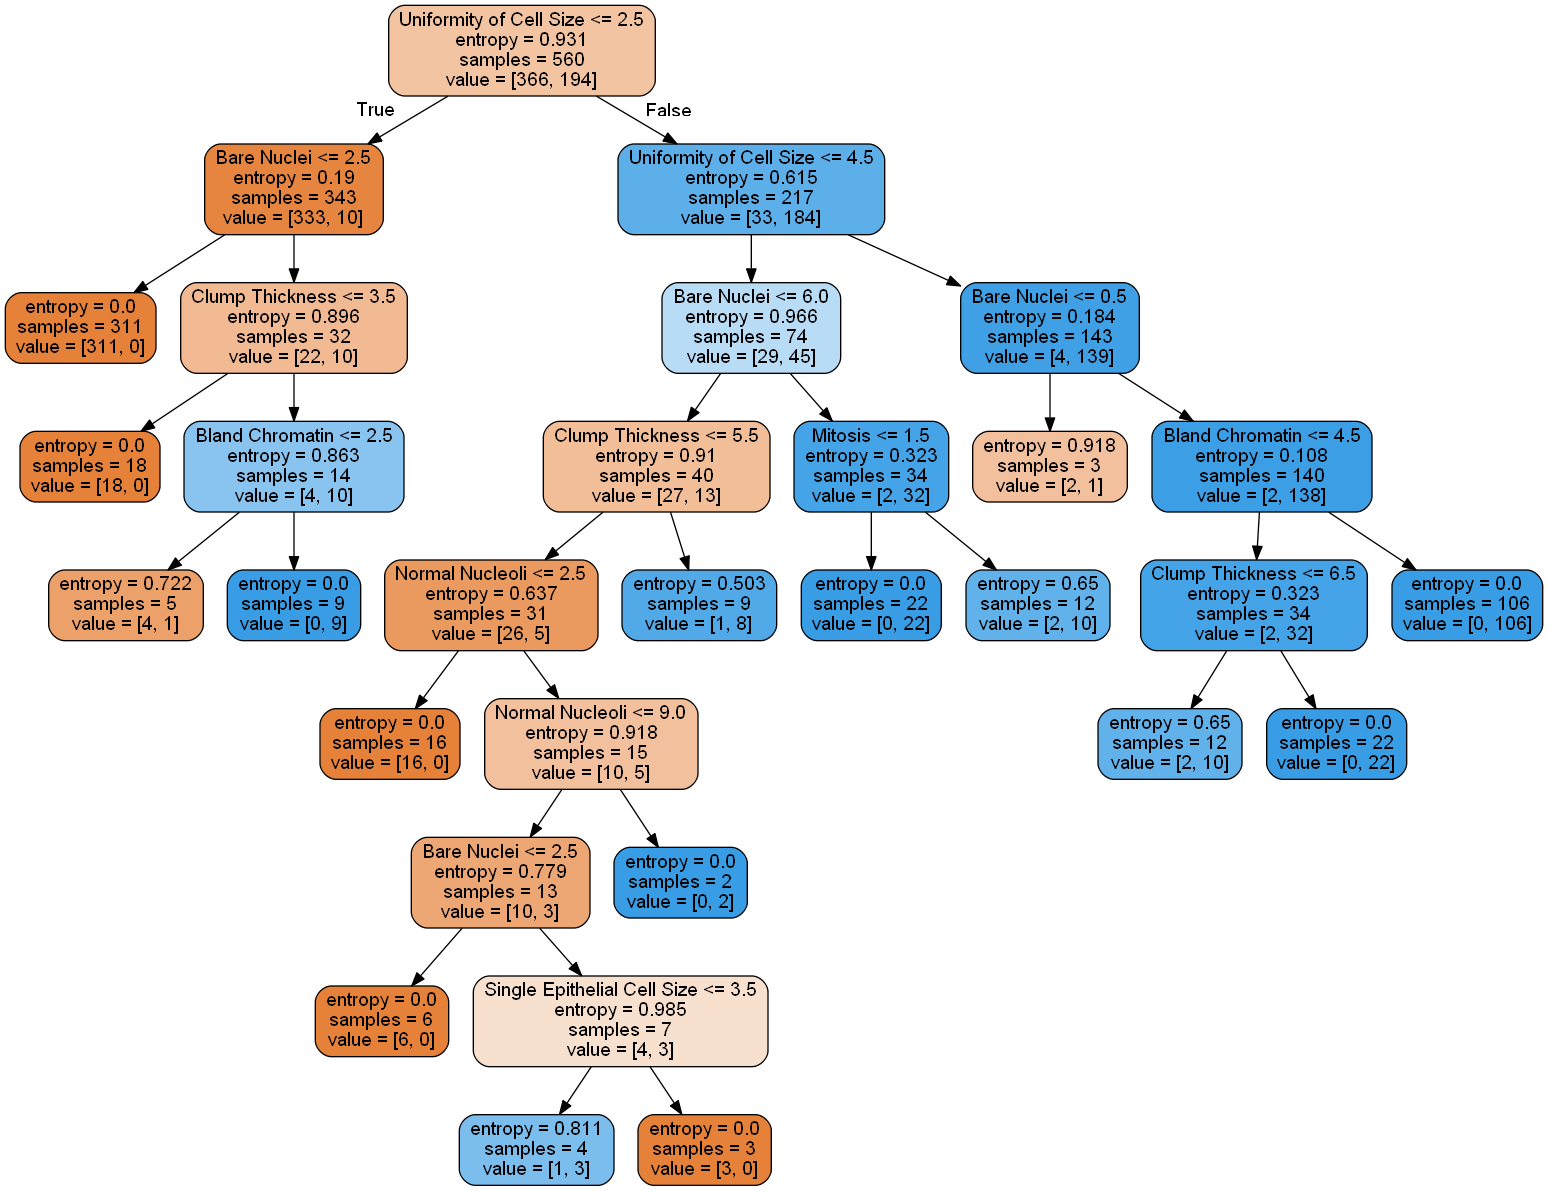

In [22]:
# best tree using entropy
#create a visualization of the tree 
dotfile = open("clf_ent_best.dot", 'w')
export_graphviz(gs_ent.best_estimator_, out_file=dotfile, filled=True, rounded=True, feature_names=X_train.columns)
dotfile.close()

# Convert the dot file to a png
os.system("dot -Tpng clf_ent_best.dot -o clf_ent_best.png");

# # Convert the dot file to a png
# from subprocess import check_call
# check_call(['dot','-Tpng','clf_ent_best.dot','-o','clf_ent_best.png'])

# show the png
print('Using entropy:')
Image(filename='clf_ent_best.png', width=1000, height=1000)

Using gini:


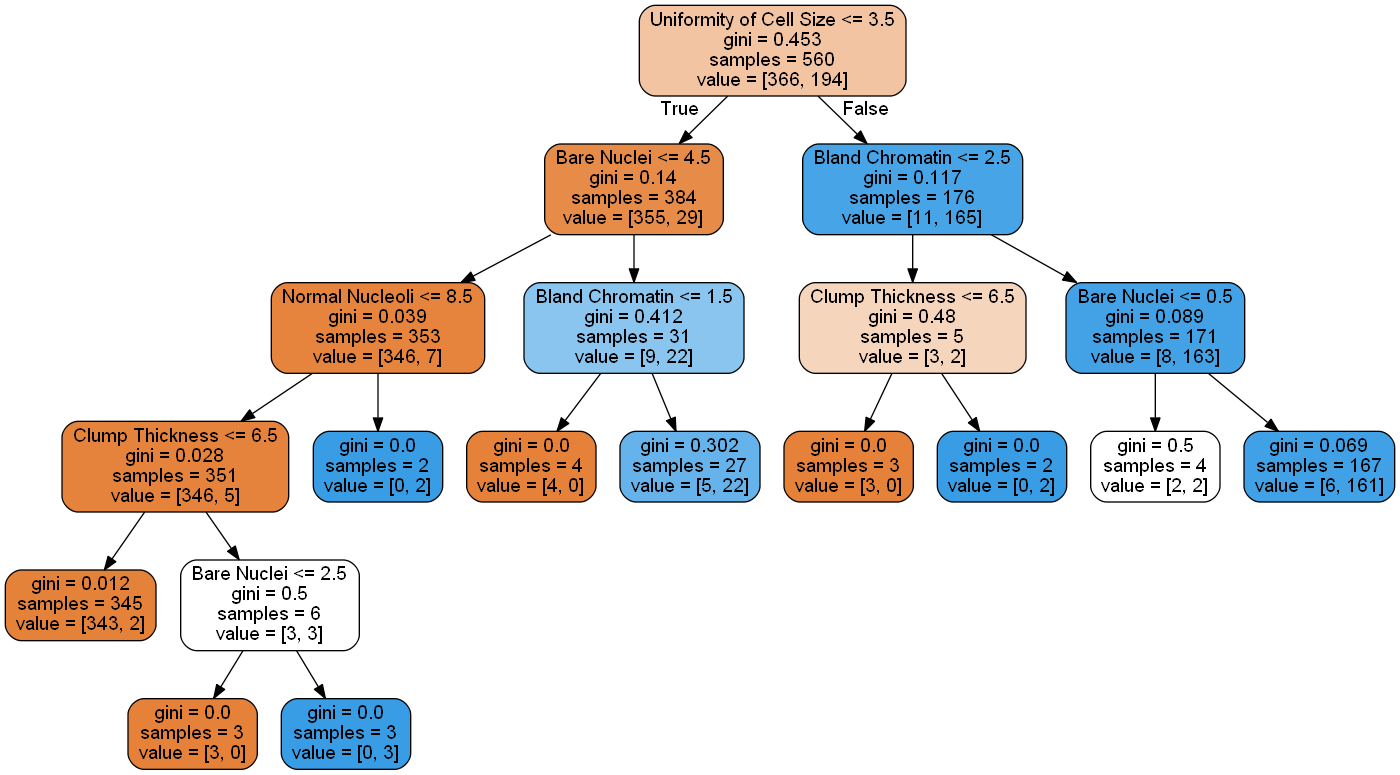

In [23]:
# best tree using gini
#create a visualization of the tree 
dotfile = open("clf_gini_best.dot", 'w')
export_graphviz(gs_gini.best_estimator_, out_file=dotfile, filled=True, rounded=True, feature_names=X_train.columns)
dotfile.close()

# Convert the dot file to a png
os.system("dot -Tpng clf_gini_best.dot -o clf_gini_best.png");

# # Convert the dot file to a png
# from subprocess import check_call
# check_call(['dot','-Tpng','clf_gini_best.dot','-o','clf_gini_best.png'])

# show the png
print('Using gini:')
Image(filename='clf_gini_best.png', width=1000, height=1000) 

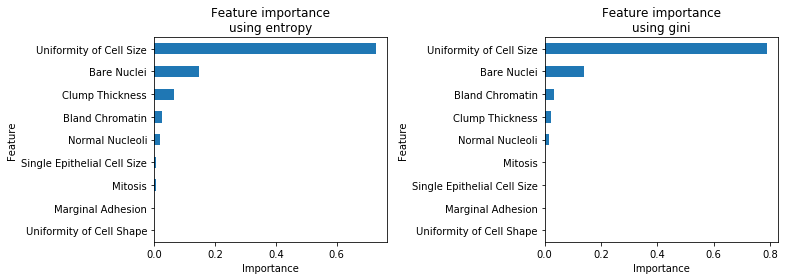

# features with zero importance
using entropy: 2
using gini: 4


In [24]:
# plot feature importantance
feat_imp_ent = pd.Series(index = X_train.columns, data = np.abs(gs_ent.best_estimator_.feature_importances_))
feat_imp_gini = pd.Series(index = X_train.columns, data = np.abs(gs_gini.best_estimator_.feature_importances_))
fig, axs = plt.subplots(1,2, figsize=(11,4))
feat_imp_ent.sort_values(ascending=False).plot(kind='barh', ax=axs[0])
feat_imp_gini.sort_values(ascending=False).plot(kind='barh', ax=axs[1])
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
axs[0].set_title('Feature importance\nusing entropy')
axs[1].set_title('Feature importance\nusing gini')
fig.tight_layout()
plt.show()

# print # features with zero importance
print('# features with zero importance\nusing entropy: {}\nusing gini: {}'.format((gs_ent.best_estimator_.feature_importances_==0).sum(), (gs_gini.best_estimator_.feature_importances_==0).sum()))

##### Results:
<ul>
    <li>Overall, the selected features were very similar between using entropy and gini, as illustrated in the feature importance plots (although gini split on fewer features)</li><p>
A closer look at the initial splits:
    <li>The first split was very similar
        <ul>
            <li>entropy: <i>Uniformity of Cell Size <= 2.5</i></li>
            <li>gini: <i>Uniformity of Cell Size <= 3.5</i></li></li>
        </ul></li><br>
   <li>Bare Nuclei was common in the next split
       <ul>
           <li>entropy: <i>Bare Nuclei <=2.5</i> and <i>Uniformity of Cell Size <=4.5</i></li>
           <li>gini: <i>Bare Nuclei <=4.5</i> and <i>Bland Chromatin <=2.5</i></li>
       </ul></li><br>
    <li>For the next split, features used become more variable
        <ul>
            <li>entropy: <i>Clump Thickness, Bland Chromatin, Mitosis</i></li>
            <li>gini: <i>Normal Nucleoli, Clump Thickness</i></li>
        </ul></li><p>
    <li>The splits are not the same because of the different criteria used to determine the split
        <ul><li>entropy: uses information gain, the expected reduction in entropy if the feature was chosen as the splitting attribute. Entropy trees tend to be more balanced compared to gini</li>
            <li>gini: uses gini impurity. Gini tree tend to be faster (greedier) and isolates the most frequently occuring class in one side of the tree</li>
        </ul></li>

##### 4. Determine the AUC for the best model you can achieve. What are the precision and recall values and which might be the one you want to maximize?

In [25]:
print('Best model using entropy:')
print(gs_ent.best_estimator_)
print ('\nAUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_gs_ent[:,1])))
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gs_ent))

print('\n\nBest model using gini:')
print(gs_gini.best_estimator_)
print ('\nAUC score: {:.3f}'.format(roc_auc_score(y_test, y_prob_gs_gini[:,1])))
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gs_gini))

Best model using entropy:
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

AUC score: 0.968

Classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96        92
         1.0       0.92      0.94      0.93        49

    accuracy                           0.95       141
   macro avg       0.94      0.95      0.95       141
weighted avg       0.95      0.95      0.95       141



Best model using gini:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0

##### Results:
The tuned/best decision tree model using entropy produced AUC of 0.968, precision of 0.92 (Class 1), and recall of 0.94 (Class 1).<br>
The tuned/best decision tree model using gini produced AUC of 0.903, precision of 0.92 (Class 1), and recall of 0.90 (Class 1).<br>
Based on these results, the tuned model using entropy performed better.

For breast cancer detection, the cost of false negatives (undetected, potentially fatal disease) arguably exceeds the cost of false positives (side effects/costs of unnecessary treatment). Thus, recall of the maglignant class (Class 1) should be maximized.

##### 5. What are the implications of using this type of machine learning algorithm for breast cancer analysis?

The decision tree model is a white box model where all decisions leading to predictions can be reviewed. Thus, predictions and actionable insights from this model are more likely to be accepted by clinicians and patients, in contrast to less interpretable models such as random forest and neural networks. This type of model could be used to guide clinician decisions.

Nevertheless, using machine learning models for medical diagnosis/predictions (where life and death decisions are at stake) is different than predicting company revenue; stating the bar is higher is an understatement. Even a recall of 0.999 means that 0.1% of the population could be misdiagnosed, which could be a very large number when considering population sizes. 